In [1]:
"""
canonical imports here
"""

import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import tensorflow_hub as hub
import numpy as np
import tensorflow_text
import datetime as dt
import re

# Data Cleanage (FR) aka Data Cleaning

## Import Data

In [2]:
#NOTE in the packages we eventually don't limit the rows to 5000
dftest = pd.read_json('../raw_data/dump.json',lines=True,nrows=500)

"""
let's choose only the features we need
"""
df = dftest[['full_text',
'lang',
'datetimestamp',
'reply_count',
'retweet_count',
'quote_count',
'created_at',
'favorite_count',
'symbols',
'hashtags']]

In [3]:
df

,full_text,lang,datetimestamp,reply_count,retweet_count,quote_count,created_at,favorite_count,symbols,hashtags
0,Расцвет человеческого общества зависит от двух...,ru,1583637560,0,0,0,2020-03-08 03:19:20+00:00,2,"[btc, alts, wan, strat, mtl, nano, nkn, kmd, z...",NaN
1,I’m waiting for the volatility to settle with ...,en,1583637637,0,0,0,2020-03-08 03:20:37+00:00,1,[btc],NaN
2,Buy $BTC this is not a fucking drill,en,1583637452,0,0,0,2020-03-08 03:17:32+00:00,2,[BTC],NaN
3,"$btc $btcusd nvm, 8,8k target hit",en,1583637470,1,0,0,2020-03-08 03:17:50+00:00,1,"[btc, btcusd]",NaN
4,"Mar 8, 2020 03:12:00 UTC The price of $BTC cur...",en,1583637182,0,0,0,2020-03-08 03:13:02+00:00,0,[BTC],NaN
...,...,...,...,...,...,...,...,...,...,...
495,Lets see if this will play out for BINANCE:DRE...,en,1595135565,0,0,0,2020-07-19 05:12:45+00:00,0,[BTC],NaN
496,Our eyes on $ONT... $BTC market on #Binance. C...,en,1595135737,0,0,0,2020-07-19 05:15:37+00:00,0,"[ONT, BTC]",[Binance]
497,DLT/BTC TRADING CHANCE for BINANCE:DLTBTC by ...,en,1595135475,0,0,0,2020-07-19 05:11:15+00:00,0,[BTC],NaN
498,Going up signal on a 30 minute chart! $BTC Pri...,en,1595135193,0,0,0,2020-07-19 05:06:33+00:00,0,[BTC],NaN


## Let's cleanse this mother…!

In [4]:
"""
Sort out \n \r \r\n in full_text column
"""

def replacen(x):
    return x.replace('\n','')
def replacer(x):
    return x.replace('\r','')
def replacern(x):
    return x.replace('\r\n','')

df['full_text'] = df['full_text'].apply(replacer)
df['full_text'] = df['full_text'].apply(replacen)
df['full_text'] = df['full_text'].apply(replacern)


# ignore pink warnings

/var/folders/fw/j6mc6mcd20379_z864ff2bfw0000gn/T/ipykernel_16288/1915096055.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text'] = df['full_text'].apply(replacer)
/var/folders/fw/j6mc6mcd20379_z864ff2bfw0000gn/T/ipykernel_16288/1915096055.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text'] = df['full_text'].apply(replacen)
/var/folders/fw/j6mc6mcd20379_z864ff2bfw0000gn/T/ipykernel_16288/1915096055.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

## Custom One-Hot Encoding for Symbol and Hashtag columns

In [5]:
df

,full_text,lang,datetimestamp,reply_count,retweet_count,quote_count,created_at,favorite_count,symbols,hashtags
0,Расцвет человеческого общества зависит от двух...,ru,1583637560,0,0,0,2020-03-08 03:19:20+00:00,2,"[btc, alts, wan, strat, mtl, nano, nkn, kmd, z...",NaN
1,I’m waiting for the volatility to settle with ...,en,1583637637,0,0,0,2020-03-08 03:20:37+00:00,1,[btc],NaN
2,Buy $BTC this is not a fucking drill,en,1583637452,0,0,0,2020-03-08 03:17:32+00:00,2,[BTC],NaN
3,"$btc $btcusd nvm, 8,8k target hit",en,1583637470,1,0,0,2020-03-08 03:17:50+00:00,1,"[btc, btcusd]",NaN
4,"Mar 8, 2020 03:12:00 UTC The price of $BTC cur...",en,1583637182,0,0,0,2020-03-08 03:13:02+00:00,0,[BTC],NaN
...,...,...,...,...,...,...,...,...,...,...
495,Lets see if this will play out for BINANCE:DRE...,en,1595135565,0,0,0,2020-07-19 05:12:45+00:00,0,[BTC],NaN
496,Our eyes on $ONT... $BTC market on #Binance. C...,en,1595135737,0,0,0,2020-07-19 05:15:37+00:00,0,"[ONT, BTC]",[Binance]
497,DLT/BTC TRADING CHANCE for BINANCE:DLTBTC by ...,en,1595135475,0,0,0,2020-07-19 05:11:15+00:00,0,[BTC],NaN
498,Going up signal on a 30 minute chart! $BTC Pri...,en,1595135193,0,0,0,2020-07-19 05:06:33+00:00,0,[BTC],NaN


In [6]:
"""
Categorize the symbol and hastag mentions for the four main culprits of this project:
- Intel (intc)
- Beyond Meat (bynd)
- General Electric (ge)
- Bitcoin (btc)
"""
# Intel
def tickerintc(x):
    if type(x) == list:
        newlist = []
        for item in x:
            newlist.append(item.lower())
        if 'intc' in newlist:
            return 1
        else:
            return 0
        
def hashtag_intc(x):
    if type(x) == list:
        newlist = []
        for item in x:
            newlist.append(item.lower())
        intc = ['intel','intc']
        if intc[0] in newlist or intc[1] in newlist:
            return 1
        else:
            return 0
        
# Beyond Meat
def tickerbynd(x):
    if type(x) == list:
        newlist = []
        for item in x:
            newlist.append(item.lower())
        if 'bynd' in newlist:
            return 1
        else:
            return 0
        
def hashtag_bynd(x):
    if type(x) == list:
        newlist = []
        for item in x:
            newlist.append(item.lower())
        bynd = ['beyondmeat','bynd']
        if bynd[0] in newlist or bynd[1] in newlist:
            return 1
        else:
            return 0
# General Electric
def tickerge(x):
    if type(x) == list:
        newlist = []
        for item in x:
            newlist.append(item.lower())
        if 'ge' in newlist:
            return 1
        else:
            return 0
        
def hashtag_ge(x):
    if type(x) == list:
        newlist = []
        for item in x:
            newlist.append(item.lower())
        ge = ['generalelectric','ge']
        if ge[0] in newlist or ge[1] in newlist:
            return 1
        else:
            return 0
        
# Bitcoin (  >:(   )   
def tickerbtc(x):
    if type(x) == list:
        newlist = []
        for item in x:
            newlist.append(item.lower())
        if 'btc' in newlist:
            return 1
        else:
            return 0
        
def hashtag_btc(x):
    if type(x) == list:
        newlist = []
        for item in x:
            newlist.append(item.lower())
        btc = ['bitcoin','btc']
        if btc[0] in newlist or btc[1] in newlist:
            return 1
        else:
            return 0
##########################################     

## Create our new one-hot encoded ticker columns and fill nans with 0

In [7]:
"""
create our new categorical columns regarding symbols (4x) and hashtags (4x)
"""
        
df['intc_ticker'] = df['symbols'].apply(tickerintc)        
df['bynd_ticker'] = df['symbols'].apply(tickerbynd)        
df['ge_ticker'] = df['symbols'].apply(tickerge)        
df['btc_ticker'] = df['symbols'].apply(tickerbtc)

df['#intc_ticker'] = df['hashtags'].apply(hashtag_intc)        
df['#bynd_ticker'] = df['hashtags'].apply(hashtag_bynd)        
df['#ge_ticker'] = df['hashtags'].apply(hashtag_ge)        
df['#btc_ticker'] = df['hashtags'].apply(hashtag_btc)

"""
fill nan values with zeros in our new columns
"""

df['intc_ticker'].fillna(0.,inplace=True)
df['bynd_ticker'].fillna(0.,inplace=True)
df['ge_ticker'].fillna(0.,inplace=True)
df['btc_ticker'].fillna(0.,inplace=True)

df['#intc_ticker'].fillna(0.,inplace=True)
df['#bynd_ticker'].fillna(0.,inplace=True)
df['#ge_ticker'].fillna(0.,inplace=True)
df['#btc_ticker'].fillna(0.,inplace=True)

# ignore pink warnings

/var/folders/fw/j6mc6mcd20379_z864ff2bfw0000gn/T/ipykernel_16288/3053683736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['intc_ticker'] = df['symbols'].apply(tickerintc)
/var/folders/fw/j6mc6mcd20379_z864ff2bfw0000gn/T/ipykernel_16288/3053683736.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bynd_ticker'] = df['symbols'].apply(tickerbynd)
/var/folders/fw/j6mc6mcd20379_z864ff2bfw0000gn/T/ipykernel_16288/3053683736.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [8]:
"""
remove nans from ticker colums
"""

df[['intc_ticker','bynd_ticker','ge_ticker','btc_ticker']].fillna(0.,inplace=True)
df[['#intc_ticker','#bynd_ticker','#ge_ticker','#btc_ticker']].fillna(0.,inplace=True)


/Users/munjikahalah/.pyenv/versions/3.8.6/envs/market_sentiment/lib/python3.8/site-packages/pandas/core/frame.py:5171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [9]:
"""
fix date time set to day without specific times
"""
df['created_at'] = df['created_at'].dt.date

/var/folders/fw/j6mc6mcd20379_z864ff2bfw0000gn/T/ipykernel_16288/2758922454.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['created_at'] = df['created_at'].dt.date


In [10]:
df

,full_text,lang,datetimestamp,reply_count,retweet_count,quote_count,created_at,favorite_count,symbols,hashtags,intc_ticker,bynd_ticker,ge_ticker,btc_ticker,#intc_ticker,#bynd_ticker,#ge_ticker,#btc_ticker
0,Расцвет человеческого общества зависит от двух...,ru,1583637560,0,0,0,2020-03-08,2,"[btc, alts, wan, strat, mtl, nano, nkn, kmd, z...",NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,I’m waiting for the volatility to settle with ...,en,1583637637,0,0,0,2020-03-08,1,[btc],NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Buy $BTC this is not a fucking drill,en,1583637452,0,0,0,2020-03-08,2,[BTC],NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,"$btc $btcusd nvm, 8,8k target hit",en,1583637470,1,0,0,2020-03-08,1,"[btc, btcusd]",NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,"Mar 8, 2020 03:12:00 UTC The price of $BTC cur...",en,1583637182,0,0,0,2020-03-08,0,[BTC],NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Lets see if this will play out for BINANCE:DRE...,en,1595135565,0,0,0,2020-07-19,0,[BTC],NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
496,Our eyes on $ONT... $BTC market on #Binance. C...,en,1595135737,0,0,0,2020-07-19,0,"[ONT, BTC]",[Binance],0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
497,DLT/BTC TRADING CHANCE for BINANCE:DLTBTC by ...,en,1595135475,0,0,0,2020-07-19,0,[BTC],NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
498,Going up signal on a 30 minute chart! $BTC Pri...,en,1595135193,0,0,0,2020-07-19,0,[BTC],NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [11]:
"""
drop columns we needn't use and check with heatmap for any gaps
"""

df.drop(['favorite_count',
         'lang',
         'datetimestamp',
         'reply_count',
         'retweet_count',
         'quote_count',
         'quote_count',
         'symbols',
         'hashtags'],axis=1,inplace=True)



/Users/munjikahalah/.pyenv/versions/3.8.6/envs/market_sentiment/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [12]:
df

,full_text,created_at,intc_ticker,bynd_ticker,ge_ticker,btc_ticker,#intc_ticker,#bynd_ticker,#ge_ticker,#btc_ticker
0,Расцвет человеческого общества зависит от двух...,2020-03-08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,I’m waiting for the volatility to settle with ...,2020-03-08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Buy $BTC this is not a fucking drill,2020-03-08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,"$btc $btcusd nvm, 8,8k target hit",2020-03-08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,"Mar 8, 2020 03:12:00 UTC The price of $BTC cur...",2020-03-08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
495,Lets see if this will play out for BINANCE:DRE...,2020-07-19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
496,Our eyes on $ONT... $BTC market on #Binance. C...,2020-07-19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
497,DLT/BTC TRADING CHANCE for BINANCE:DLTBTC by ...,2020-07-19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
498,Going up signal on a 30 minute chart! $BTC Pri...,2020-07-19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [13]:
"""
remove links away from full_text
"""

def remove_urls(text):
    text = re.sub(r'https?://\S+', '', text)
    return text

df['full_text'] = df['full_text'].apply(remove_urls)

/var/folders/fw/j6mc6mcd20379_z864ff2bfw0000gn/T/ipykernel_16288/4161786243.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text'] = df['full_text'].apply(remove_urls)


# !! DANGR ZONE !! DO NOT RUN CODE BELOW UNLESS SMALLER DATA

### Make sure data frame does NOT SURPASS 7000 rows!

In [14]:
"""
create a vextor embedding matrix per tweet into a new dataframe variable vector_df
"""

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
text_result = embed(df['full_text'])
vector_df = pd.DataFrame(text_result.numpy())

2021-09-08 12:42:06.503227: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-08 12:42:09.331024: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


# Breathe in, out, and let's check the dataframes we have for comparison

In [15]:
vector_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.000039,-0.048648,-0.043249,-0.057029,0.045178,0.028709,-0.047446,-0.059832,0.031897,0.017609,...,-0.026220,0.071336,-0.035513,-0.056909,0.043171,-0.037478,-0.007179,-0.009458,0.013665,0.005449
1,-0.000881,0.006815,-0.104014,-0.102300,-0.089217,0.008585,-0.041062,-0.048969,-0.008564,0.040399,...,-0.053123,-0.057954,0.072325,-0.070757,0.027566,0.002492,0.086193,-0.012549,-0.012987,0.072317
2,0.000568,0.029366,-0.084870,-0.087521,0.033559,0.040141,-0.035663,0.004321,-0.050664,0.001826,...,-0.078234,-0.037736,0.001215,-0.020226,0.067014,0.047181,0.051067,-0.043411,-0.016759,0.061772
3,0.022832,0.036749,-0.079850,-0.088448,-0.063727,0.062514,0.000688,0.024882,0.013593,0.016426,...,-0.024541,-0.051545,0.054564,-0.058412,0.022247,0.010616,0.059010,0.050027,0.039830,0.002944
4,-0.007395,0.053267,-0.086250,-0.085443,0.031137,0.008982,-0.065417,0.012812,0.076530,-0.061635,...,0.029155,-0.070193,0.068606,-0.023226,0.088063,0.013789,0.021891,-0.019742,0.039208,0.028317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.011227,0.030469,-0.092886,-0.044053,0.040251,0.053895,-0.006724,0.061708,-0.066054,-0.011100,...,-0.032527,-0.029751,0.048473,-0.012185,0.056345,0.007580,0.029598,-0.021142,-0.019833,0.057031
496,0.005554,0.043346,-0.085973,-0.078450,0.031009,0.052815,-0.027363,-0.019374,-0.044784,0.027579,...,-0.020706,-0.067009,-0.011056,-0.056647,0.043762,0.027751,0.000873,-0.032868,-0.029790,0.027135
497,0.050649,0.043159,-0.084370,-0.081448,0.030022,0.021708,-0.004397,0.023151,-0.012543,0.048957,...,0.030791,-0.055356,0.019211,-0.067877,0.053888,0.028446,0.036099,0.021240,0.029986,0.028105
498,0.007281,-0.021996,-0.090506,-0.077669,0.030558,0.027622,-0.033786,-0.003630,0.021609,0.032306,...,-0.001497,-0.068395,0.024867,-0.051677,0.046643,-0.023168,0.046326,0.008692,0.008332,0.045740


In [16]:
df

,full_text,created_at,intc_ticker,bynd_ticker,ge_ticker,btc_ticker,#intc_ticker,#bynd_ticker,#ge_ticker,#btc_ticker
0,Расцвет человеческого общества зависит от двух...,2020-03-08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,I’m waiting for the volatility to settle with ...,2020-03-08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Buy $BTC this is not a fucking drill,2020-03-08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,"$btc $btcusd nvm, 8,8k target hit",2020-03-08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,"Mar 8, 2020 03:12:00 UTC The price of $BTC cur...",2020-03-08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
495,Lets see if this will play out for BINANCE:DRE...,2020-07-19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
496,Our eyes on $ONT... $BTC market on #Binance. C...,2020-07-19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
497,DLT/BTC TRADING CHANCE for BINANCE:DLTBTC by ...,2020-07-19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
498,Going up signal on a 30 minute chart! $BTC Pri...,2020-07-19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [17]:
"""
concat the two dataframes one against another to create one single dataframe
"""

df = pd.concat([df,vector_df], axis=1, join="inner")

In [18]:
df

,full_text,created_at,intc_ticker,bynd_ticker,ge_ticker,btc_ticker,#intc_ticker,#bynd_ticker,#ge_ticker,#btc_ticker,...,502,503,504,505,506,507,508,509,510,511
0,Расцвет человеческого общества зависит от двух...,2020-03-08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.026220,0.071336,-0.035513,-0.056909,0.043171,-0.037478,-0.007179,-0.009458,0.013665,0.005449
1,I’m waiting for the volatility to settle with ...,2020-03-08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.053123,-0.057954,0.072325,-0.070757,0.027566,0.002492,0.086193,-0.012549,-0.012987,0.072317
2,Buy $BTC this is not a fucking drill,2020-03-08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.078234,-0.037736,0.001215,-0.020226,0.067014,0.047181,0.051067,-0.043411,-0.016759,0.061772
3,"$btc $btcusd nvm, 8,8k target hit",2020-03-08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.024541,-0.051545,0.054564,-0.058412,0.022247,0.010616,0.059010,0.050027,0.039830,0.002944
4,"Mar 8, 2020 03:12:00 UTC The price of $BTC cur...",2020-03-08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.029155,-0.070193,0.068606,-0.023226,0.088063,0.013789,0.021891,-0.019742,0.039208,0.028317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Lets see if this will play out for BINANCE:DRE...,2020-07-19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.032527,-0.029751,0.048473,-0.012185,0.056345,0.007580,0.029598,-0.021142,-0.019833,0.057031
496,Our eyes on $ONT... $BTC market on #Binance. C...,2020-07-19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.020706,-0.067009,-0.011056,-0.056647,0.043762,0.027751,0.000873,-0.032868,-0.029790,0.027135
497,DLT/BTC TRADING CHANCE for BINANCE:DLTBTC by ...,2020-07-19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.030791,-0.055356,0.019211,-0.067877,0.053888,0.028446,0.036099,0.021240,0.029986,0.028105
498,Going up signal on a 30 minute chart! $BTC Pri...,2020-07-19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.001497,-0.068395,0.024867,-0.051677,0.046643,-0.023168,0.046326,0.008692,0.008332,0.045740


## Choose conditional dataframes for tickers and hashtags

In [19]:
"""
select the dataframes for when the symbol tickers have a hit
"""

intc_ticker_df = df[df['intc_ticker']==1.]
bynd_ticker_df = df[df['bynd_ticker']==1.]
ge_ticker_df = df[df['ge_ticker']==1.]
btc_ticker_df = df[df['btc_ticker']==1.]

"""
select the dataframes for when the hashtag tickers have a hit
"""

intc_hash_ticker_df = df[df['#intc_ticker']==1.]
bynd_hash_ticker_df = df[df['#bynd_ticker']==1.]
ge_hash_ticker_df = df[df['#ge_ticker']==1.]
btc_hash_ticker_df = df[df['#btc_ticker']==1.]

In [20]:
print(bynd_ticker_df.shape)

(23, 522)


In [21]:
intc_ticker_mean_df = intc_ticker_df.groupby('created_at').mean()
bynd_ticker_mean_df = bynd_ticker_df.groupby('created_at').mean()
ge_ticker_mean_df = ge_ticker_df.groupby('created_at').mean()
btc_ticker_mean_df = btc_ticker_df.groupby('created_at').mean()
                   
intc_hash_ticker_mean_df = intc_hash_ticker_df.groupby('created_at').mean()
bynd_hash_ticker_mean_df = bynd_hash_ticker_df.groupby('created_at').mean()
ge_hash_ticker_mean_df = ge_hash_ticker_df.groupby('created_at').mean()
btc_hash_ticker_mean_df = btc_hash_ticker_df.groupby('created_at').mean()

In [22]:
bynd_ticker_mean_df

,intc_ticker,bynd_ticker,ge_ticker,btc_ticker,#intc_ticker,#bynd_ticker,#ge_ticker,#btc_ticker,0,1,...,502,503,504,505,506,507,508,509,510,511
created_at,,,,,,,,,,,,,,,,,,,,,
2019-06-14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.011852,0.008092,...,-0.034015,-0.002214,-0.000570,-0.009186,0.057567,0.008314,0.018037,-0.028814,-0.000803,0.046753
2019-10-25,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.013291,0.013535,...,-0.023658,-0.005672,-0.004129,-0.018427,0.067344,-0.006569,-0.017021,-0.033615,-0.012393,0.046574
2019-10-26,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034070,0.060616,...,0.013301,0.003671,0.061916,-0.073697,0.028719,-0.012967,0.024824,-0.000307,-0.045121,0.066337
2020-03-07,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.013993,-0.071369,...,0.036747,0.044816,-0.014061,-0.089031,0.048097,-0.004494,0.038570,-0.020462,-0.038359,0.030116
2020-03-08,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.052620,0.008726,...,0.025805,-0.018463,0.001743,-0.055318,0.064253,-0.016390,0.015572,-0.040030,-0.023210,-0.008869
2020-07-19,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.056724,0.010779,...,-0.102111,0.005111,-0.075783,0.031971,0.037248,-0.055883,-0.009738,-0.004623,-0.000163,0.102063
2021-08-25,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.004323,-0.059290,...,0.005105,0.027875,-0.045597,-0.079223,0.060957,-0.014134,0.063673,-0.025426,-0.028738,-0.009994


In [23]:
(bynd_ticker_mean_df).shape

(7, 520)

In [24]:
bynd_hash_ticker_mean_df.shape

(0, 520)

In [25]:
bynd_hash_ticker_mean_df

,intc_ticker,bynd_ticker,ge_ticker,btc_ticker,#intc_ticker,#bynd_ticker,#ge_ticker,#btc_ticker,0,1,...,502,503,504,505,506,507,508,509,510,511
created_at,,,,,,,,,,,,,,,,,,,,,


In [26]:
"""
convert created_at index from object to datetime 
"""
# symbol ticker dfs
intc_ticker_mean_df.index = pd.to_datetime(intc_ticker_mean_df.index)
bynd_ticker_mean_df.index = pd.to_datetime(bynd_ticker_mean_df.index)
ge_ticker_mean_df.index = pd.to_datetime(ge_ticker_mean_df.index)
btc_ticker_mean_df.index = pd.to_datetime(btc_ticker_mean_df.index)
# hashtag ticker dfs
intc_hash_ticker_mean_df.index = pd.to_datetime(intc_hash_ticker_mean_df.index)
bynd_hash_ticker_mean_df.index = pd.to_datetime(bynd_hash_ticker_mean_df.index)
ge_hash_ticker_mean_df.index = pd.to_datetime(ge_hash_ticker_mean_df.index)
btc_hash_ticker_mean_df.index = pd.to_datetime(btc_hash_ticker_mean_df.index)

# Import Target Dataframe

In [27]:
import yfinance as yf

tickers = yf.download(tickers = 'INTC BYND GE BTC', interval='1d',  period = "1y")

[*********************100%***********************]  4 of 4 completed


In [28]:
tickers

Adj Close                                         Close  \
                  BTC        BYND          GE       INTC        BTC   
Date                                                                  
2020-09-08        NaN  134.470001   48.920536  47.658722        NaN   
2020-09-09        NaN  138.169998   49.079887  48.350555        NaN   
2020-09-10        NaN  143.039993   47.805088  47.707436        NaN   
2020-09-11        NaN  134.880005   47.406708  48.019253        NaN   
2020-09-14        NaN  143.179993   49.000214  48.145927        NaN   
...               ...         ...         ...        ...        ...   
2021-08-31  99.695000  119.639999  105.410004  54.060001  99.695000   
2021-09-01  99.680000  120.760002  103.660004  53.669998  99.680000   
2021-09-02  99.720200  119.739998  106.260002  53.730000  99.720200   
2021-09-03        NaN  114.970001  104.750000  53.509998        NaN   
2021-09-07  99.555099  113.730003  103.290001  53.650002  99.555099   

                                                    High              ...  \
                  BYND          GE       INTC        BTC        BYND  ...   
Date                                                                  ...   
2020-09-08  134.470001   49.119999  48.910000        NaN  137.779999  ...   
2020-09-09  138.169998   49.279999  49.619999        NaN  139.470001  ...   
2020-09-10  143.039993   48.000000  48.959999        NaN  149.570007  ...   
2020-09-11  134.880005   47.599998  49.279999        NaN  144.070007  ...   
2020-09-14  143.179993   49.200001  49.410000        NaN  145.369995  ...   
...                ...         ...        ...        ...         ...  ...   
2021-08-31  119.639999  105.410004  54.060001  99.695000  122.355003  ...   
2021-09-01  120.760002  103.660004  53.669998  99.719002  122.320000  ...   
2021-09-02  119.739998  106.260002  53.730000  99.760002  122.264999  ...   
2021-09-03  114.970001  104.750000  53.509998        NaN  118.570000  ...   
2021-09-07  113.730003  103.290001  53.650002  99.575996  115.779999  ...   

                   Low                  Open                          \
                    GE       INTC        BTC        BYND          GE   
Date                                                                   
2020-09-08   49.040001  48.849998        NaN  123.809998   50.560001   
2020-09-09   48.160000  49.040001        NaN  132.500000   49.599998   
2020-09-10   48.000000  48.709999        NaN  139.399994   49.360001   
2020-09-11   47.439999  48.950001        NaN  144.000000   48.320000   
2020-09-14   47.680000  48.849998        NaN  136.149994   47.919998   
...                ...        ...        ...         ...         ...   
2021-08-31  104.459999  53.660000  99.650002  121.309998  104.940002   
2021-09-01  103.260002  53.529999  99.719002  119.080002  105.360001   
2021-09-02  103.980003  53.349998  99.760002  120.529999  104.000000   
2021-09-03  104.080002  53.320000        NaN  118.000000  106.000000   
2021-09-07  102.309998  53.439999  99.575996  115.129997  104.500000   

                         Volume                               
                 INTC       BTC     BYND        GE      INTC  
Date                                                          
2020-09-08  49.259998       NaN  7318300  15080750  39752700  
2020-09-09  49.529999       NaN  4381400  13630538  33437300  
2020-09-10  50.000000       NaN  8189300  12165600  32649100  
2020-09-11  49.259998       NaN  3989200   8989825  29333600  
2020-09-14  48.849998       NaN  4812000   9250263  27212500  
...               ...       ...      ...       ...       ...  
2021-08-31  54.439999  126287.0  1808700  10990800  22350100  
2021-09-01  54.110001     103.0  1499000   7968100  18615000  
2021-09-02  53.799999     572.0  1209200   8493700  15869500  
2021-09-03  53.439999       NaN  4310900   7616900  13456200  
2021-09-07  53.570000     862.0  2290000  10989500  13901300  

[252 rows x 24 columns]

In [29]:
bynd_first = tickers['Close']['BYND'][-1]
bynd_latest = tickers['Close']['BYND'][-2]
bynd_latest - bynd_first

1.2399978637695312

In [30]:
firsttt = tickers['Close']['GE'][0]
secnd = tickers['Close']['GE'][1]
secnd - firsttt

0.15999984741210938

In [31]:
tickers['Close']['GE']

Date
2020-09-08     49.119999
2020-09-09     49.279999
2020-09-10     48.000000
2020-09-11     47.599998
2020-09-14     49.200001
                 ...    
2021-08-31    105.410004
2021-09-01    103.660004
2021-09-02    106.260002
2021-09-03    104.750000
2021-09-07    103.290001
Name: GE, Length: 252, dtype: float64

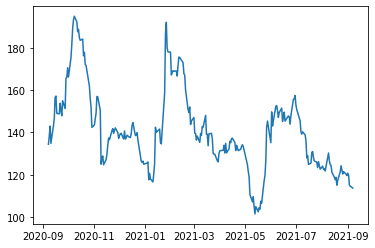

In [32]:
plt.plot(tickers['Close']['BYND'])

# Encode the output to give us our target series

In [33]:
"""
Convert tickers to 1 and 0 as target output series
"""

INTCclose = tickers['Close']['INTC']
BYNDclose = tickers['Close']['BYND']
GEclose = tickers['Close']['GE']
BTCclose = tickers['Close']['BTC']

def onezero(x):
    if x>0:
        return 1
    else:
        return 0

intc_target_df = pd.Series(INTCclose).diff().apply(onezero)
bynd_target_df = pd.Series(BYNDclose).diff().apply(onezero)
ge_target_df = pd.Series(GEclose).diff().apply(onezero)
btc_target_df = pd.Series(BTCclose).diff().apply(onezero)

In [34]:
BTCclose

Date
2020-09-08          NaN
2020-09-09          NaN
2020-09-10          NaN
2020-09-11          NaN
2020-09-14          NaN
                ...    
2021-08-31    99.695000
2021-09-01    99.680000
2021-09-02    99.720200
2021-09-03          NaN
2021-09-07    99.555099
Name: BTC, Length: 252, dtype: float64

# Merge our target series to the data frame matching one of the 4 market culprits we're looking at

In [35]:
bynd_ticker_mean_df.shape

(7, 520)

In [36]:
bynd_target_df.shape

(252,)

In [37]:
"""
Merge ticker feature selected aggredated dataframe with target target dataframe created
"""

INTC_df = pd.merge(intc_ticker_mean_df,intc_target_df,left_index=True,right_index=True)

In [38]:
"""
Merge ticker feature selected aggredated dataframe with target target dataframe created
"""

BYND_df = pd.merge(bynd_ticker_mean_df,bynd_target_df,left_index=True,right_index=True)

In [39]:
"""
Merge ticker feature selected aggredated dataframe with target target dataframe created
"""

GE_df = pd.merge(ge_ticker_mean_df,ge_target_df,left_index=True,right_index=True)

In [40]:
"""
Merge ticker feature selected aggredated dataframe with target target dataframe created
"""

BTC_df = pd.merge(btc_ticker_mean_df,btc_target_df,left_index=True,right_index=True)

In [41]:
INTC_df

,intc_ticker,bynd_ticker,ge_ticker,btc_ticker,#intc_ticker,#bynd_ticker,#ge_ticker,#btc_ticker,0,1,...,503,504,505,506,507,508,509,510,511,INTC
2021-04-14,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.004434,-0.034692,...,-0.000191,-0.048394,-0.081380,0.059130,-0.011539,0.063351,-0.045436,-0.007201,0.031951,0
2021-08-25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045879,0.063103,...,-0.052967,-0.014123,-0.078606,-0.009865,0.012133,0.028318,-0.071641,0.039515,0.012662,0


In [42]:
BYND_df

,intc_ticker,bynd_ticker,ge_ticker,btc_ticker,#intc_ticker,#bynd_ticker,#ge_ticker,#btc_ticker,0,1,...,503,504,505,506,507,508,509,510,511,BYND
2021-08-25,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.004323,-0.05929,...,0.027875,-0.045597,-0.079223,0.060957,-0.014134,0.063673,-0.025426,-0.028738,-0.009994,0


In [43]:
GE_df

,intc_ticker,bynd_ticker,ge_ticker,btc_ticker,#intc_ticker,#bynd_ticker,#ge_ticker,#btc_ticker,0,1,...,503,504,505,506,507,508,509,510,511,GE


In [44]:
BTC_df

,intc_ticker,bynd_ticker,ge_ticker,btc_ticker,#intc_ticker,#bynd_ticker,#ge_ticker,#btc_ticker,0,1,...,503,504,505,506,507,508,509,510,511,BTC
2021-04-14,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.372093,0.007386,0.006685,...,-0.048682,0.013613,-0.072307,0.045916,0.018252,-0.004998,-0.015825,0.007289,0.026784,0
2021-08-25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.225000,0.015952,0.006755,...,-0.048481,0.001798,-0.064526,0.042391,0.016307,0.001963,-0.024745,0.003492,0.036016,0


# We not have four data frames with a target and aggregated vectorization. The dataframes are named:
### - INTC_df
### - BYND_df
### - GE_df
### - BTC

In [45]:
import tweepy

In [46]:
consumer_key= "Aab7LOGZyppaFPNDQCdZ44yK7"
consumer_secret = "CYdlRUzGTAPVrQdaa0XfuoTeDNyo1EHb2AuDsoevmlwWTYUkFM"

access_token = "2182508549-jVF957pWQp2znpsd0kw54soL7TZkFwrJsQTusNV"

access_token_secret= "HW9mwAvbO4KnwgZmk7C4LZa2mKqvTorHPokLeSHRF0FKE"

In [47]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret )
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [48]:
tweets_GE = api.search(q ="$GE", count = 50)
tweets_BYND = api.search(q ="$BYND", count = 50)
tweets_INTC = api.search(q ="$INTC", count = 50)
tweets_BTC = api.search(q ="$BTC", count = 50)

In [49]:
tweets_GE_list = []
tweets_BYND_list = []
tweets_INTC_list = []
tweets_BTC_list = []

In [50]:
json_data_GE = [r._json for r in tweets_GE]
json_data_BYND = [r._json for r in tweets_BYND]
json_data_BTC = [r._json for r in tweets_BTC]
json_data_INTC = [r._json for r in tweets_INTC]


In [51]:
for tweet in json_data_GE:
    tweets_GE_list.append({'created_at': tweet['created_at'], 'text': tweet['text']})

In [52]:
for tweet in json_data_BYND:
    tweets_BYND_list.append({'created_at': tweet['created_at'], 'text': tweet['text']})

In [53]:
for tweet in json_data_BTC:
    tweets_BTC_list.append({'created_at': tweet['created_at'], 'text': tweet['text']})

In [54]:
for tweet in json_data_INTC:
    tweets_INTC_list.append({'created_at': tweet['created_at'], 'text': tweet['text']})

In [55]:
tweets_GE_list

[{'created_at': 'Wed Sep 08 10:22:11 +0000 2021',
  'text': 'RT @frankoz95967943: @business so long $ge $luv $ba'},
 {'created_at': 'Wed Sep 08 10:18:04 +0000 2021',
  'text': '@DelhiPolice @CPDelhi 15.43 Power supply again cut by @DelhiPolice in Rajokri in attempt to murder $GE #GE  whistle… https://t.co/UjsPcokkPq'},
 {'created_at': 'Wed Sep 08 10:17:46 +0000 2021',
  'text': '@dcpouter @DelhiPolice @CPDelhi @SanjaySingh_IPS @DCPSEastDelhi @dcp_southwest @dcprohinidelhi @DcpCrime… https://t.co/8nsTr7pD4C'},
 {'created_at': 'Wed Sep 08 10:17:25 +0000 2021',
  'text': '@reliancegroup @RInfraOfficial 15.43 Power supply again cut by @DelhiPolice in Rajokri in attempt to murder $GE #GE… https://t.co/BD9oUUCCnK'},
 {'created_at': 'Wed Sep 08 10:17:09 +0000 2021',
  'text': '@LtGovDelhi 15.43 Power supply again cut by @DelhiPolice in Rajokri in attempt to murder $GE #GE  whistleblower See… https://t.co/FwtsBf455n'},
 {'created_at': 'Wed Sep 08 10:17:02 +0000 2021',
  'text': '@LtGovDelhi Al

In [56]:
tweets_BYND_list

[{'created_at': 'Wed Sep 08 10:41:25 +0000 2021',
  'text': '**Starting with $10k, down to $5k, back up to $70k, Lot of thanks to this chat https://t.co/mhuHXNQPYD\n\n$TRCH $TWTR… https://t.co/fyKvHUuAKc'},
 {'created_at': 'Wed Sep 08 10:36:08 +0000 2021',
  'text': 'RT @warrior16win: $NXMH We as a company, predict that success in the USA 🇺🇸 market will lead to more than 👉🏼 100 times 👈🏼 the growth as of…'},
 {'created_at': 'Wed Sep 08 10:36:03 +0000 2021',
  'text': 'RT @warrior16win: $NXMH @nextmeats All three products will be launched in October through the Next Meats online store \n\n👉🏼 More details wil…'},
 {'created_at': 'Wed Sep 08 10:18:21 +0000 2021',
  'text': "RT @podvolochysk: For anyone who cares, here's my full portfolio. 100% long, no margin, no options.\n\nHypergrowth: ~80% weight\n$TSLA\n$SQ\n$ZG…"},
 {'created_at': 'Wed Sep 08 10:02:23 +0000 2021',
  'text': 'RT @WaynePa18855635: **Starting with $10k, down to $5k, back up to $70k, Lot of thanks to this chat https://t.c

In [57]:
tweets_INTC_list

[{'created_at': 'Wed Sep 08 10:19:34 +0000 2021',
  'text': "A Peek Into The Markets: US Stock Futures Down Ahead Of Fed's Beige Book\n\nRelated Tickers: $INTC $GME $LULU $HRC… https://t.co/xezQI0G6eV"},
 {'created_at': 'Wed Sep 08 10:16:23 +0000 2021',
  'text': 'Intel resumed with a Hold at Deutsche Bank\n$INTC'},
 {'created_at': 'Wed Sep 08 10:13:58 +0000 2021',
  'text': 'Intel resumed with a Hold at Deutsche Bank\n$INTC'},
 {'created_at': 'Wed Sep 08 10:05:45 +0000 2021',
  'text': 'RT @value_invest12: Look at this🤓\n\n1st graph is Apple, up 478% last 5ys. \n2nd graph is Intel, up 47% last 5ys. \n\nApple’s PE is 30\nIntels PE…'},
 {'created_at': 'Wed Sep 08 09:56:08 +0000 2021',
  'text': 'RT @mukund: The Corporate venture arms of $GOOG $CRM $QCOM $MSFT $INTC https://t.co/qd9w9QiAq2'},
 {'created_at': 'Wed Sep 08 09:51:04 +0000 2021',
  'text': '$INTC Real price will come out soon! Congrats to all members who followed this chatroom:-\n\nhttps://t.co/oLn54ET3cc'},
 {'created_at': '

In [58]:
tweets_BTC_list

[{'created_at': 'Wed Sep 08 10:42:17 +0000 2021',
  'text': "RT @BTCSkye: Peter Schiff may very well be the best #bitcoin salesman I've ever seen 🤣🤣🤣\n\nHe tweets about every single major news about $BT…"},
 {'created_at': 'Wed Sep 08 10:42:17 +0000 2021',
  'text': 'RT @cryptoastblog: Conséquences les plus parlantes de l’introduction du #Bitcoin en tant que monnaie légale au Salvador 🇸🇻, les grandes mul…'},
 {'created_at': 'Wed Sep 08 10:42:13 +0000 2021',
  'text': '$BTC Price: $46058\n$ETH Price: $3333\n$LTC Price: $179\n\nNext update in 10 minutes\nLast updated: 6:42:11.03'},
 {'created_at': 'Wed Sep 08 10:42:11 +0000 2021',
  'text': 'RT @doge_cola: We are here today 🔥👀\n\nTOP 10 Most viewed projects on @CoinMarketCap\n\nhttps://t.co/MNXqq9LcpO\n\n#DogeCola #MoonTaste #beverage…'},
 {'created_at': 'Wed Sep 08 10:42:02 +0000 2021',
  'text': '#ADAPad @ADApadofficial launching with a $29K Market Cap soon! Get in on the action here #ETH $KCS $KCC #KCC $BNB… https://t.co/jAjXohvvXm'},

In [59]:
df = pd.json_normalize(json_data_GE)
# df2 =pd.json_normalize(json_data_BYND) 
# df3 = 

In [60]:
concat_tweets = tweets_GE_list +  tweets_BYND_list + tweets_INTC_list + tweets_BTC_list

In [61]:
final_df = pd.DataFrame.from_dict(concat_tweets)

In [62]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  200 non-null    object
 1   text        200 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [63]:
final_df

,created_at,text
0,Wed Sep 08 10:22:11 +0000 2021,RT @frankoz95967943: @business so long $ge $lu...
1,Wed Sep 08 10:18:04 +0000 2021,@DelhiPolice @CPDelhi 15.43 Power supply again...
2,Wed Sep 08 10:17:46 +0000 2021,@dcpouter @DelhiPolice @CPDelhi @SanjaySingh_I...
3,Wed Sep 08 10:17:25 +0000 2021,@reliancegroup @RInfraOfficial 15.43 Power sup...
4,Wed Sep 08 10:17:09 +0000 2021,@LtGovDelhi 15.43 Power supply again cut by @D...
...,...,...
195,Wed Sep 08 10:40:42 +0000 2021,@CoinDesk @godbole17 $BTC may be on its way to...
196,Wed Sep 08 10:40:41 +0000 2021,RT @coingecko: Gentle reminder to look at the ...
197,Wed Sep 08 10:40:41 +0000 2021,RT @WyckoffAnalysis: #Bitcoin No comment. Just...
198,Wed Sep 08 10:40:40 +0000 2021,"Bullish unlocks, bullish ddos..\n\nNext: bulli..."


In [64]:
# df = df[['created_at', 'text']]

In [65]:
# df['text']

In [66]:
# df['text'][0]

In [67]:
def df_to_datetime(df):
    df.index = pd.to_datetime(df.index)
    return df

In [68]:
# final_df['created_at'] = pd.to_datetime(final_df["created_at"])

In [81]:
final_df = df_to_datetime(final_df)

In [83]:
final_df.index

DatetimeIndex([          '1970-01-01 00:00:00',
               '1970-01-01 00:00:00.000000001',
               '1970-01-01 00:00:00.000000002',
               '1970-01-01 00:00:00.000000003',
               '1970-01-01 00:00:00.000000004',
               '1970-01-01 00:00:00.000000005',
               '1970-01-01 00:00:00.000000006',
               '1970-01-01 00:00:00.000000007',
               '1970-01-01 00:00:00.000000008',
               '1970-01-01 00:00:00.000000009',
               ...
               '1970-01-01 00:00:00.000000190',
               '1970-01-01 00:00:00.000000191',
               '1970-01-01 00:00:00.000000192',
               '1970-01-01 00:00:00.000000193',
               '1970-01-01 00:00:00.000000194',
               '1970-01-01 00:00:00.000000195',
               '1970-01-01 00:00:00.000000196',
               '1970-01-01 00:00:00.000000197',
               '1970-01-01 00:00:00.000000198',
               '1970-01-01 00:00:00.000000199'],
              dtype=

In [88]:
final_df

,created_at,text,symbols
1970-01-01 00:00:00.000000000,Wed Sep 08 10:22:11 +0000 2021,RT @frankoz95967943: @business so long $ge $lu...,"[$ge, $luv, $ba]"
1970-01-01 00:00:00.000000001,Wed Sep 08 10:18:04 +0000 2021,@DelhiPolice @CPDelhi 15.43 Power supply again...,[$GE]
1970-01-01 00:00:00.000000002,Wed Sep 08 10:17:46 +0000 2021,@dcpouter @DelhiPolice @CPDelhi @SanjaySingh_I...,[]
1970-01-01 00:00:00.000000003,Wed Sep 08 10:17:25 +0000 2021,@reliancegroup @RInfraOfficial 15.43 Power sup...,[$GE]
1970-01-01 00:00:00.000000004,Wed Sep 08 10:17:09 +0000 2021,@LtGovDelhi 15.43 Power supply again cut by @D...,[$GE]
...,...,...,...
1970-01-01 00:00:00.000000195,Wed Sep 08 10:40:42 +0000 2021,@CoinDesk @godbole17 $BTC may be on its way to...,[$BTC]
1970-01-01 00:00:00.000000196,Wed Sep 08 10:40:41 +0000 2021,RT @coingecko: Gentle reminder to look at the ...,[$BTC]
1970-01-01 00:00:00.000000197,Wed Sep 08 10:40:41 +0000 2021,RT @WyckoffAnalysis: #Bitcoin No comment. Just...,[$BTC]
1970-01-01 00:00:00.000000198,Wed Sep 08 10:40:40 +0000 2021,"Bullish unlocks, bullish ddos..\n\nNext: bulli...",[$BTC]


In [70]:
def find_tickers(text):
    return re.findall(r'[$][A-Za-z][\S]*', text)

In [71]:
final_df['symbols'] = final_df['text'].apply(find_tickers)


In [72]:
final_df['symbols']


0      [$ge, $luv, $ba]
1                 [$GE]
2                    []
3                 [$GE]
4                 [$GE]
             ...       
195              [$BTC]
196              [$BTC]
197              [$BTC]
198              [$BTC]
199              [$BTC]
Name: symbols, Length: 200, dtype: object

In [73]:
# re.findall(r'[$][A-Za-z][\S]*', df['text'])`

In [74]:
df['text'][8]

'@bsesdelhi 15.43 Power supply again cut by @DelhiPolice in Rajokri in attempt to murder $GE #GE  whistleblower Seem… https://t.co/d1yDAj9eSR'